# General setup

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Imports

In [3]:
# Standard data processing & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, roc_auc_score, 
                           confusion_matrix, classification_report)
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

# My three classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# For reproducibility
RANDOM_SEED = 42

Create functions

In [4]:
def get_classifiers():
    """Return dictionary of classifiers with initial parameters"""
    classifiers = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,  # Start with 100 trees
            random_state=RANDOM_SEED,
            n_jobs=-1  # Use all CPU cores
        ),
        
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(100,),  # Start with one hidden layer
            max_iter=1000,
            random_state=RANDOM_SEED
        ),
        
        'SVM': SVC(
            kernel='rbf',
            probability=True,  # Needed for ROC curves
            random_state=RANDOM_SEED
        )
    }
    return classifiers

# Function to create different train-test splits
def create_splits(X, y):
    """Create different train-test splits (20-80, 50-50, 80-20)"""
    splits = {}
    
    # 20-80 split
    X_train_20, X_test_80, y_train_20, y_test_80 = train_test_split(
        X, y, train_size=0.2, random_state=RANDOM_SEED)
    splits['20-80'] = (X_train_20, X_test_80, y_train_20, y_test_80)
    
    # 50-50 split
    X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(
        X, y, train_size=0.5, random_state=RANDOM_SEED)
    splits['50-50'] = (X_train_50, X_test_50, y_train_50, y_test_50)
    
    # 80-20 split
    X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(
        X, y, train_size=0.8, random_state=RANDOM_SEED)
    splits['80-20'] = (X_train_80, X_test_20, y_train_80, y_test_20)
    
    return splits

In [5]:
# Define parameter grids for cross-validation
def get_param_grids():
    """Define parameter grids for each classifier"""
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        },
        'Neural Network': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'alpha': [0.0001, 0.001],
            'learning_rate_init': [0.001, 0.01]
        },
        'SVM': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.1],
            'kernel': ['rbf', 'linear']
        }
    }
    return param_grids

In [6]:
def run_experiment_with_cv(X, y, trial_num):
    """Run experiment with cross-validation for hyperparameter tuning"""
    results = []
    param_grids = get_param_grids()
    splits = create_splits(X, y)
    base_classifiers = get_classifiers()
    
    for split_name, (X_train, X_test, y_train, y_test) in splits.items():
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        for clf_name, base_clf in tqdm(base_classifiers.items(), 
                                     desc=f'Trial {trial_num+1}, Split {split_name}'):
            # Perform GridSearchCV
            grid_search = GridSearchCV(
                estimator=base_clf,
                param_grid=param_grids[clf_name],
                cv=5,
                scoring='roc_auc',
                n_jobs=-1
            )
            
            # Fit and get best model
            grid_search.fit(X_train_scaled, y_train)
            best_clf = grid_search.best_estimator_
            
            # Make predictions
            y_pred = best_clf.predict(X_test_scaled)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, best_clf.predict_proba(X_test_scaled)[:,1])
            
            # Store results
            results.append({
                'trial': trial_num,
                'split': split_name,
                'classifier': clf_name,
                'accuracy': accuracy,
                'roc_auc': roc_auc,
                'best_params': str(grid_search.best_params_)
            })
    
    return pd.DataFrame(results)

In [7]:
def plot_learning_curves(X, y, classifier_name, classifier):
    """Plot learning curves for a classifier"""
    train_sizes = np.linspace(0.1, 1.0, 5)
    
    train_sizes, train_scores, test_scores = learning_curve(
        classifier, X, y,
        train_sizes=train_sizes, cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')
    
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1)
    
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curves for {classifier_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Heart Disease dataset

Source: https://archive.ics.uci.edu/dataset/45/heart+disease

### Data setup

In [8]:
# Load the heart disease dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data = pd.read_csv(url, names=columns, na_values='?')

In [9]:
# Basic data exploration
print("Dataset Shape:", data.shape)
print("\nFirst few rows:")
print(data.head())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(data.describe())

# Class distribution
print("\nClass distribution:")
print(data['target'].value_counts())

Dataset Shape: (303, 14)

First few rows:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  

Missing values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

Basic statistics:
              age         sex          cp    trestbps        chol     

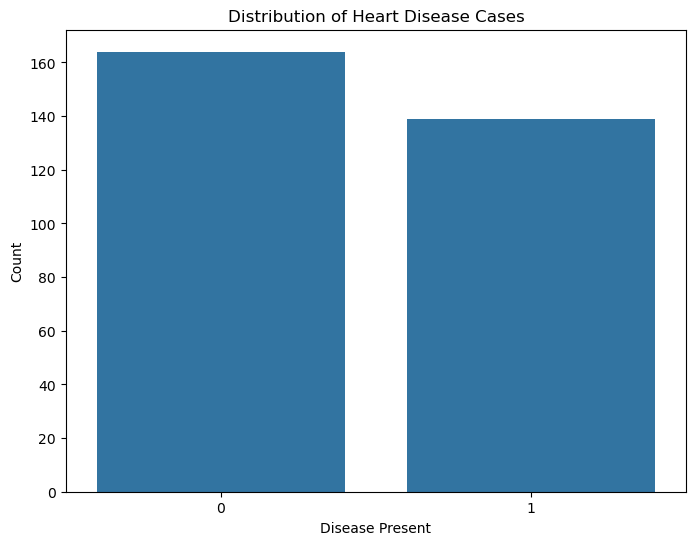

In [10]:
# Convert target to binary (0 for no disease, 1 for disease)
data['target'] = data['target'].map(lambda x: 1 if x > 0 else 0)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='target')
plt.title('Distribution of Heart Disease Cases')
plt.xlabel('Disease Present')
plt.ylabel('Count')
plt.show()

# Split features and target
X = data.drop('target', axis=1)
y = data['target']

# Handle any missing values
if X.isnull().any().any():
    X = X.fillna(X.mean())

### Run experiments

In [11]:
print("Running experiments with cross-validation...")
all_results = []
for trial in range(3):
    trial_results = run_experiment_with_cv(X, y, trial)
    all_results.append(trial_results)

# Combine and analyze results
final_results = pd.concat(all_results, ignore_index=True)
avg_performance = final_results.groupby(['split', 'classifier'])[['accuracy', 'roc_auc']].mean()

# Print results
print("\nAverage Performance:")
print(avg_performance)

Running experiments with cross-validation...


Trial 3, Split 80-20: 100%|██████████| 3/3 [00:32<00:00, 10.70s/it]


Average Performance:
                      accuracy   roc_auc
split classifier                        
20-80 Neural Network  0.777778  0.832177
      Random Forest   0.786008  0.886033
      SVM             0.806584  0.904257
50-50 Neural Network  0.763158  0.847743
      Random Forest   0.828947  0.906424
      SVM             0.809211  0.923090
80-20 Neural Network  0.819672  0.877155
      Random Forest   0.885246  0.942888
      SVM             0.901639  0.934267


In [12]:
# Print best parameters for each classifier
print("\nBest Parameters:")
for clf in final_results['classifier'].unique():
    print(f"\n{clf}:")
    params = final_results[final_results['classifier'] == clf]['best_params'].iloc[0]
    print(params)


Best Parameters:

Random Forest:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Neural Network:
{'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}

SVM:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


<Figure size 1200x600 with 0 Axes>

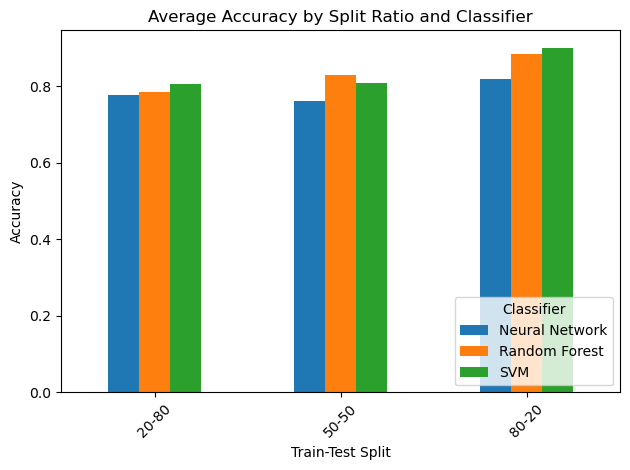

<Figure size 1200x600 with 0 Axes>

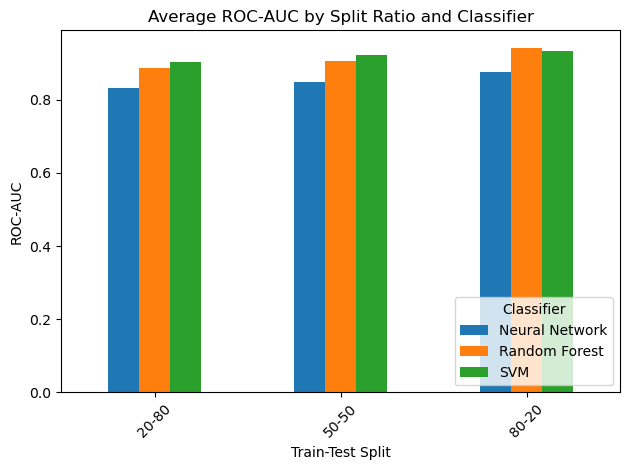

In [19]:
plt.figure(figsize=(12, 6))
avg_performance['accuracy'].unstack().plot(kind='bar')
plt.title('Average Accuracy by Split Ratio and Classifier')
plt.xlabel('Train-Test Split')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Classifier', loc='lower right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
avg_performance['roc_auc'].unstack().plot(kind='bar')
plt.title('Average ROC-AUC by Split Ratio and Classifier')
plt.xlabel('Train-Test Split')
plt.ylabel('ROC-AUC')
plt.xticks(rotation=45)
plt.legend(title='Classifier', loc='lower right')
plt.tight_layout()
plt.show()